# 项目说明 
基于前面的模型和训练结果
根据新的给定不同字体、不同字符间隔的图片
重新训练针对该“模式”下的验证码识别


# 导入要用到的包

In [ ]:
import torch
from PIL import Image
import random
import time
import os
import numpy as np
from torch.autograd import Variable
!/opt/bin/nvidia-smi

Mon May 11 10:26:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 外部数据处理方式
可以直接挂载到Google drive，但是可能io会影响到读取速度，而且本实验的数据可以模拟生成，故：才去每次试验前生成数据，10w条train大概需要8分钟

In [ ]:
import glob
# import os
# from google.colab import drive
# drive.mount('/content/drive')
drive_path = "/content/drive/My Drive"
# os.chdir(drive_path)

# 一些配置参数，存储路径、字符长度、字符种类，字体设置、验证码噪声等等

In [ ]:
# 需要用到的一些验证码的常量
# 验证码中的字符
# string.digits + string.ascii_uppercase
CHAR_SET = '0123456789'+'ABCDEFGHIJKLMNOPQRSTUVWXYZ'+'abcdefghijklmnopqrstuvwxyz'						  # 图片字符集合
CPATCHA_LEN = 4									  # 每张图片字符的个数
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
ALPHABET2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# 所有字符类别集
ALL_CHAR_SET = NUMBER + ALPHABET + ALPHABET2
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
CHAR_MAP = dict(zip(list(CHAR_SET), range(len(CHAR_SET))))
# 一张图片中字符的个数
MAX_CAPTCHA = 4
# 图像大小
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 160
FONT_SIZE = [40,45,50]
# IMAGE_HEIGHT = 40
# IMAGE_WIDTH = 100
# 离线训练模式的数据存取路径设置
TRAIN_DATASET_PATH = 'dataset' + os.path.sep + 'chr_len_62'+ os.path.sep + 'train'
VAL_DATASET_PATH = 'dataset' + os.path.sep + 'chr_len_62'+ os.path.sep + 'val'
TEST_DATASET_PATH = 'dataset' + os.path.sep + 'chr_len_62'+ os.path.sep + 'test'
PREDICT_DATASET_PATH = 'dataset' + os.path.sep + 'predict'
# 超参数
BATCH_SIZE = 64
GROUP_LEN_TRAIN = 4 # 相当于数据增强
GROUP_LEN_VAL = 2
LEARNING_RATE = 0.001
EXPORT_FILE_NAME = 'model.pth'
# 可选字体的格式
MY_FONTS = glob.glob(drive_path+'/fonts/*.ttf')
# CHOOSE_FONTS = [f for f in MY_FONTS if 'bold' in f ]
CHOOSE_FONTS = MY_FONTS

In [ ]:
CHOOSE_FONTS

['/content/drive/My Drive/fonts/outline-Pokemon-Solid-2.ttf',
 '/content/drive/My Drive/fonts/outline-Pokemon-Hollow-1.ttf',
 '/content/drive/My Drive/fonts/outline-GROBOLD-1.ttf',
 '/content/drive/My Drive/fonts/3d-orange-juice-2-0-1.ttf',
 '/content/drive/My Drive/fonts/outline-1.ttf',
 '/content/drive/My Drive/fonts/normal_Quarlow-3.ttf',
 '/content/drive/My Drive/fonts/bold_Bevan-2.ttf',
 '/content/drive/My Drive/fonts/hand_OCEAN-6-Brushed-Black-Edition-2.ttf',
 '/content/drive/My Drive/fonts/hand_Black-Vosten-Personal-Use-3.ttf',
 '/content/drive/My Drive/fonts/cute_Yikes-2.ttf',
 '/content/drive/My Drive/fonts/hand_Cartagena-Regular-2.ttf',
 '/content/drive/My Drive/fonts/cute_babyground.ttf',
 '/content/drive/My Drive/fonts/bold_Donaldson-3.ttf',
 '/content/drive/My Drive/fonts/normal_DroidSansMono.ttf',
 '/content/drive/My Drive/fonts/normal_PingFang-SC-Regular.ttf',
 '/content/drive/My Drive/fonts/hand_Victoria-ALwW6-2.ttf',
 '/content/drive/My Drive/fonts/cute_a-Arbei-Berry-3

# 完整流程包括以下四步
1. Prepare data    数据准备
2. Build model     模型定义
3. Train model     训练模型
4. Analyse results 分析结果

## 1. 准备数据 ETL 阶段

In [ ]:
# 对label进行one-hot 编码
def encode(text):
    vector = np.zeros(ALL_CHAR_SET_LEN * MAX_CAPTCHA, dtype=float)
    def char2pos(c):
        if c =='_':
            k = 62
            return k
        k = ord(c)-48
        if k > 9:
            k = ord(c) - 65 + 10
            if k > 35:
                k = ord(c) - 97 + 26 + 10
                if k > 61:
                    raise ValueError('error')
        return k
    for i, c in enumerate(text):
        idx = i * ALL_CHAR_SET_LEN + char2pos(c)
        vector[idx] = 1.0
    return vector
def char2label(cs):
    label_code = [CHAR_MAP[c] for c in cs]
    vector = np.zeros(ALL_CHAR_SET_LEN * MAX_CAPTCHA, dtype=float)
    for i, c in enumerate(label_code):
        idx = i * ALL_CHAR_SET_LEN + c
        vector[idx] = 1.0
    return vector
def decode(vec):
    char_pos = vec.nonzero()[0]
    text=[]
    for i, c in enumerate(char_pos):
        char_at_pos = i #c/63
        char_idx = c % ALL_CHAR_SET_LEN
        if char_idx < 10:
            char_code = char_idx + ord('0')
        elif char_idx <36:
            char_code = char_idx - 10 + ord('A')
        elif char_idx < 62:
            char_code = char_idx - 36 + ord('a')
        elif char_idx == 62:
            char_code = ord('_')
        else:
            raise ValueError('error')
        text.append(chr(char_code))
    return "".join(text)
# 把一批图片的labels的onehot转换成标签编码
# ys_one_hot.shape = [batch_size,4*len(CHAR_SET)]
def onehot2labelcode(ys_one_hot):
    labels_code = []
    for i in range(ys_one_hot.shape[0]):
        label_code = []
        for j in range(CPATCHA_LEN):
            label_code.append(np.argmax(ys_one_hot[i,j*ALL_CHAR_SET_LEN:(j+1)*ALL_CHAR_SET_LEN]).item())
        labels_code.append(label_code)
    return torch.tensor(labels_code)

### 1.0 My_ImageCaptcha--修改自第三方包

In [ ]:
# coding: utf-8
"""
    captcha.image
    ~~~~~~~~~~~~~
    Generate Image CAPTCHAs, just the normal image CAPTCHAs you are using.
"""
import os
import random
from PIL import Image
from PIL import ImageFilter
from PIL.ImageDraw import Draw
from PIL.ImageFont import truetype
from PIL.ImageOps import colorize
from io import BytesIO

# FONT_DIR = os.path.join(os.path.abspath(os.path.dirname(__file__)), 'fonts')
# DEFAULT_FONTS = [os.path.join(FONT_DIR, 'Chalk-Line-Outline-1.ttf')]

__all__ = ['ImageCaptcha']
class _Captcha(object):
    def generate(self, chars, format='png'):
        """Generate an Image Captcha of the given characters.
        :param chars: text to be generated.
        :param format: image file format
        """
        im = self.generate_image(chars)
        out = BytesIO()
        im.save(out, format=format)
        out.seek(0)
        return out

    def write(self, chars, output, format='png'):
        """Generate and write an image CAPTCHA data to the output.

        :param chars: text to be generated.
        :param output: output destination.
        :param format: image file format
        """
        im = self.generate_image(chars)
        return im.save(output, format=format)
    def generate_image(self, chars):
        raise NotImplemented
class My_ImageCaptcha(_Captcha):
    """Create an image CAPTCHA.
    :param width: The width of the CAPTCHA image.
    :param height: The height of the CAPTCHA image.
    :param fonts: Fonts to be used to generate CAPTCHA images.
    :param font_sizes: Random choose a font size from this parameters.
    """
    def __init__(self, width=160, height=64, fonts=None, font_sizes=None):
        self._width = width
        self._height = height
        self._fonts = fonts or CHOOSE_FONTS
        self._font_sizes = font_sizes or range(int(0.7*height), int(0.95*height),6) # 字体大小随着图片大小变化
        self._truefonts = []

    @property
    def truefonts(self):
        if self._truefonts:
            return self._truefonts
        self._truefonts = tuple([
            truetype(n, s)
            for n in self._fonts
            for s in self._font_sizes
        ])
        return self._truefonts
    @staticmethod
    def create_noise_curve(image):
        w, h = image.size
        line_number = random.randint(1, 3)
        while line_number > 0:
            color = random_color(100, 200, random.randint(220, 255))
            x1 = random.randint(0, int(w / 2))
            x2 = random.randint(w - int(w / 2), w)
            y1 = random.randint(0, h)
            y2 = random.randint(0, h)
            points = [x1, y1, x2, y2]
            Draw(image).line(points, fill=color)  # 直线
            # Draw(image).arc(points, start, end, fill=color) # 曲线
            line_number -= 1
        return image
    @staticmethod
    def create_noise_dots(image, width=1, number=30):
        draw = Draw(image)
        w, h = image.size
        while number:
            color = random_color(10, 150)
            x1 = random.randint(0, w)
            y1 = random.randint(0, h)
            draw.rectangle(((x1, y1), (x1 + 1, y1 + 1)), fill=color, width=width)
            number -= 1
        return image
    def _draw_character(self, c):
        font = random.choice(self.truefonts)
        txt_w, txt_h = font.getsize(c)
        # dx,dy 表示字符大小范围（随机性）
        dx = random.randint(0, 4)
        dy = random.randint(0, 6)
        txt_image = Image.new('L', (txt_w + dx, txt_h + dy))
        Draw(txt_image).text((dx, dy), c, font=font, fill=255)
        # rotate
        txt_image = txt_image.crop(txt_image.getbbox())
        angle = random.randint(-30, 30)
        txt_image = txt_image.rotate(angle, Image.BILINEAR, expand=1)
        return txt_image
    def create_captcha_image(self, chars, background):
        """Create the CAPTCHA image itself.

        :param chars: text to be generated.
        :param background: color of the background.

        The color should be a tuple of 3 numbers, such as (0, 255, 255).
        """
        image = Image.new('RGB', (self._width, self._height), background)

        images = []
        for c in chars:
            images.append(self._draw_character(c))

        text_width = sum([im.size[0] for im in images])
        width = max(text_width, self._width)

        average = int(text_width / len(chars))    # 平均每个字符的所占的像素宽度
        rand = int(0.2 * average)      #
        offset = int(0.1 * average)    # 水平上的偏移 x
        # 字符与字符的间距，紧凑可以按需调整
        for i, txt_im in enumerate(images):
            w, h = txt_im.size
            c_color = random_color(70, 150)
            # 下面的 x，y表示的是image_txt的左上角在image上的坐标
            x, y = (offset, int((self._height - h) / 2))
            image.paste(colorize(txt_im, (0, 0, 0), c_color), (x, y), txt_im)
            offset = offset + w + random.randint(-rand,0)

        if width > self._width:
            image = image.resize((self._width, self._height))
        return image
    def generate_image(self, chars):
        """Generate the image of the given characters.

        :param chars: text to be generated.
        """
        background = random_color(200, 220)
        captcha_img = self.create_captcha_image(chars, background)
        self.create_noise_dots(captcha_img)
        self.create_noise_curve(captcha_img)
        return captcha_img
def random_color(start, end, opacity=None):
    red = random.randint(start, end)
    green = random.randint(start, end)
    blue = random.randint(start, end)
    if opacity is None:
        return red, green, blue
    return red, green, blue, opacity


### 1.1离线数据集dataset（采样）

In [ ]:
# 数据准备
# 生成验证码的代码片段
! pip install captcha
from captcha.image import ImageCaptcha
# 产生随机的四个字符
def random_captcha():
    captcha_text = random.choices(ALL_CHAR_SET,k=MAX_CAPTCHA)
    return ''.join(captcha_text)
# 生成字符对应的验证码
def gen_captcha_text_and_image():
    image = My_ImageCaptcha(width=IMAGE_WIDTH,height=IMAGE_HEIGHT,fonts=CHOOSE_FONTS,font_sizes=FONT_SIZE)
    captcha_text = random_captcha()
    captcha_image = Image.open(image.generate(captcha_text))
    return captcha_text, captcha_image
def captcha_gen(model_choose = 'train',num=1000):
    count = num
    if model_choose=='train':
        path = TRAIN_DATASET_PATH
    if model_choose=='test':
        path = TEST_DATASET_PATH  #通过改变此处目录，以生成 训练、测试和预测用的验证码集
    if model_choose=='val':
        path = VAL_DATASET_PATH
    if not os.path.exists(path):
        os.makedirs(path)
    for i in range(count):
        now = str(int(time.time()))
        text, image = gen_captcha_text_and_image()
        filename = text+'_'+now+'.png'
        image.save(path  + os.path.sep +  filename)
        print('saved %d : %s' % (i+1,filename))
# 制作数据集
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
class mydataset(Dataset):
    def __init__(self, folder, transform=None):
        self.train_image_file_paths = [os.path.join(folder, image_file) for image_file in os.listdir(folder)]
        self.transform = transform
    def __len__(self):
        return len(self.train_image_file_paths)
    def __getitem__(self, idx):
        image_root = self.train_image_file_paths[idx]
        image_name = image_root.split(os.path.sep)[-1]
        image = Image.open(image_root)
        if self.transform is not None:
            image = self.transform(image)
        label = encode(image_name.split('_')[0]) # 为了方便，在生成图片的时候，图片文件的命名格式 "4个数字或者数字_时间戳.PNG", 4个字母或者即是图片的验证码的值，字母大写,同时对该值做 one-hot 处理
        return image, label
transform = transforms.Compose([
    # transforms.ColorJitter(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def get_train_data_loader(batch_size=64):
    dataset = mydataset(TRAIN_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)
def get_val_data_loader(batch_size=64):
    dataset = mydataset(VAL_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)
def get_test_data_loader():
    dataset = mydataset(TEST_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=1, shuffle=True)
def get_predict_data_loader():
    dataset = mydataset(PREDICT_DATASET_PATH, transform=transform)
    return DataLoader(dataset, batch_size=1, shuffle=True)

     |████████████████████████████████| 102kB 2.3MB/s 


### 1.2在线数据集dataset（总体）
--不区分训练验证测试，因为训练集的也不会重复
注意：label也要编码成one-hot的格式，总之要与模型输出与损失函数相对应
CNN_captcha：5层，多标签的损失函数
CNN:8层，多标签损失函数

In [ ]:
class mydataset_online(Dataset):
    def __init__(self, width=IMAGE_WIDTH, height=IMAGE_HEIGHT, char_length=CPATCHA_LEN, input_channel=1, char_set=CHAR_SET, len_set = 64*100,group_len=8,fonts=CHOOSE_FONTS, font_sizes=FONT_SIZE):
        """在线生成图片用于模型训练
        :param width: 图像的宽度
        :param height: 图像的高度
        :param char_length: 每张图像包含的字符长度
        :param input_channel: 生成图像的通道数，1对应着灰度图，3对应着RGB图像
        :param char_set: 候选字符集合
        :param fonts: 字体文件路径
        :param font_sizes: 字体大小
        """
        self.transform = transforms.ToTensor()
        self.input_channel = input_channel
        self.char_set = char_set
        self.captcha_generator = My_ImageCaptcha(width=width, height=height, fonts=fonts, font_sizes=font_sizes)
        self.len_set = len_set
        self.group_len = group_len
        self.char_length = char_length
    def __getitem__(self, item):
        return self.gen_captcha()

    def gen_captcha(self):
        """每一个标签生成8张图像
        """
        chars = random.choices(self.char_set, k=self.char_length)
        label = char2label(chars) # one-hot 型的label
        image_tensors = []
        image_labels = []
        if self.input_channel == 1:
            mode = 'L'
        elif self.input_channel == 3:
            mode = 'RGB'
        else:
            raise ValueError("Unknown input_channel value: {}".format(self.input_channel))
        for i in range(self.group_len):
            cap_img = self.captcha_generator.generate_image(chars).convert(mode)
            image_tensors.append(self.transform(cap_img))
            image_labels.append(torch.tensor(label))

        image_tensors = torch.stack(image_tensors, 0)
        image_labels = torch.stack(image_labels, 0)

        return image_tensors, image_labels

    def __len__(self):
        return self.len_set
def get_train_data_loader_online(batch_size=BATCH_SIZE,len_set = BATCH_SIZE*200,group_len=GROUP_LEN_TRAIN):
    dataset = mydataset_online(len_set = len_set,group_len=group_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def get_val_data_loader_online(batch_size=BATCH_SIZE,len_set = BATCH_SIZE*10,group_len=GROUP_LEN_VAL):
    dataset = mydataset_online(len_set = len_set,group_len=group_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 2. 模型定义
这里包括了两个模型

*   基础的3层卷积+2层全连接
*   更深一点的6层卷积+2层全连接

这里可以适当进行调整
1. 多少层卷积
2. 每一层卷积用多大的核（3x3）、用多少个核（channel数）
3. 全连接层的层数（2-3层）、全连接层的宽度（不大于1024）



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### 2.0 (2+1)-两层卷积+一层池化

#### 浅层朴素模型 无BN
 2+1 :conv_block = [conv + conv + pool]
不加那些最后用来提升效果的技巧的：
比如batchnorm，dropout等

In [ ]:
# ************************ step-2 Build model ************************
# 卷积块的结构
# padding为了大小不变，pool为了尺寸减半
def conv_block_CNN_naive_2(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
    )
class CNN_naive_2(nn.Module):
    def __init__(self):
        super(CNN_naive_2, self).__init__()
        self.feature_extractor = nn.Sequential(
          conv_block_CNN_naive_2(1, 32),
          conv_block_CNN_naive_2(32, 64),
          conv_block_CNN_naive_2(64, 96),
        )
        self.fc = nn.Sequential(
          nn.Linear((IMAGE_WIDTH//8)*(IMAGE_HEIGHT//8)*96, 1024),   # TODO: 2592可能随着输入维度的改变需要调整          
          nn.ReLU(),
          nn.Linear(1024, CPATCHA_LEN * len(CHAR_SET))
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)   # 如果用one-hot的话，多标签分类的话就用这个模型的输出[batch_size,4*62]
        # logits = logits.view((-1, len(CHAR_SET), CPATCHA_LEN)) # 用交叉熵损失的时候，就用这个模型的输出 [batch_size,62,4]
        return logits

#### 浅层模型（5）BN

In [ ]:
# ************************ step-2 Build model ************************
# 卷积块的结构
# padding为了大小不变，pool为了尺寸减半
def conv_block_CNN_light_2(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
    )
class CNN_light_2(nn.Module):
    def __init__(self):
        super(CNN_light_2, self).__init__()
        self.feature_extractor = nn.Sequential(
          conv_block_CNN_light_2(1, 32),
          conv_block_CNN_light_2(32, 64),
          conv_block_CNN_light_2(64, 96),
        )
        self.fc = nn.Sequential(
          nn.Linear((IMAGE_WIDTH//8)*(IMAGE_HEIGHT//8)*96, 1024),   # TODO: 2592可能随着输入维度的改变需要调整
          nn.ReLU(),
          nn.Linear(1024, CPATCHA_LEN * len(CHAR_SET))
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)   # 如果用one-hot的话，多标签分类的话就用这个模型的输出[batch_size,4*62]
        # logits = logits.view((-1, len(CHAR_SET), CPATCHA_LEN)) # 用交叉熵损失的时候，就用这个模型的输出 [batch_size,62,4]
        return logits

#### 加深模型（8）BN

In [ ]:
# ************************ step-2 Build model ************************
# 卷积块的结构
# padding为了大小不变，pool为了尺寸减半
def conv_block_CNN_deep_2(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
    )
class CNN_deep_2(nn.Module):
    def __init__(self):
        super(CNN_deep_2, self).__init__()
        self.feature_extractor = nn.Sequential(
          conv_block_CNN_deep_2(1, 32),
          conv_block_CNN_deep_2(32, 64),
          conv_block_CNN_deep_2(64, 96),
          conv_block_CNN_deep_2(96, 128),
        )
        self.fc = nn.Sequential(
          nn.Linear((IMAGE_WIDTH//16)*(IMAGE_HEIGHT//16)*128, 1024),   # TODO: 2592可能随着输入维度的改变需要调整
          nn.ReLU(),
          nn.Linear(1024, CPATCHA_LEN * len(CHAR_SET))
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)   # 如果用one-hot的话，多标签分类的话就用这个模型的输出[batch_size,4*62]
        # logits = logits.view((-1, len(CHAR_SET), CPATCHA_LEN)) # 用交叉熵损失的时候，就用这个模型的输出 [batch_size,62,4]
        return logits

#### 减少FC的数量（防止过拟合）

In [ ]:
# ************************ step-2 Build model ************************
# 卷积块的结构
# padding为了大小不变，pool为了尺寸减半
def conv_block_CNN_deeper_2(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
    )
class CNN_deeper_2(nn.Module):
    def __init__(self):
        super(CNN_deeper_2, self).__init__()
        self.feature_extractor = nn.Sequential(
          conv_block_CNN_deeper_2(1, 32),
          conv_block_CNN_deeper_2(32, 64),
          conv_block_CNN_deeper_2(64, 64),
          conv_block_CNN_deeper_2(64, 128),
        )
        self.fc = nn.Sequential(
          nn.Linear((IMAGE_WIDTH//16)*(IMAGE_HEIGHT//16)*128, 512),   # TODO: 2592可能随着输入维度的改变需要调整
          nn.ReLU(),
          nn.Linear(512, CPATCHA_LEN * len(CHAR_SET))
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)   # 如果用one-hot的话，多标签分类的话就用这个模型的输出[batch_size,4*62]
        # logits = logits.view((-1, len(CHAR_SET), CPATCHA_LEN)) # 用交叉熵损失的时候，就用这个模型的输出 [batch_size,62,4]
        return logits

### 2.1 (1+1)-一层卷积+一层池化

#### 浅层朴素模型 无BN
conv_block = [conv + pool]

In [ ]:
# 模型定义
# 模型1：浅层的模型
import torch.nn as nn
class CNN_naive_1(nn.Module):
    def __init__(self):
        super(CNN_naive_1,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # (batch_size=64,num_channel=1,60,160)-->(batch_size=64,num_channel=32,60,160)
            # nn.BatchNorm2d(32),                         # 参数个数：卷积核个数 32 * 每个卷积核 3x3=9 = 288
            nn.ReLU(),
            nn.MaxPool2d(2))                            # (batch_size=64,num_channel=32,60,160)-->(batch_size=64,num_channel=32,30,80)
        self.layer2 = nn.Sequential(                    
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# (batch_size=64,num_channel=32,30,80)-->(batch_size=64,num_channel=64,30,80)
            # nn.BatchNorm2d(64),                         # 参数个数：卷积核个数 64 * 每个卷积核 3x3=9 = 576
            nn.ReLU(),
            nn.MaxPool2d(2))                            # (batch_size=64,num_channel=64,30,80)-->(batch_size=64,num_channel=64,15,40)
        self.layer3 = nn.Sequential(                    
            nn.Conv2d(64, 64, kernel_size=3, padding=1),# (batch_size=64,num_channel=64,15,40)-->(batch_size=64,num_channel=64,15,40)
            # nn.BatchNorm2d(64),                         # 参数个数：卷积核个数 64 * 每个卷积核 3x3=9 = 576
            nn.ReLU(),      
            nn.MaxPool2d(2))                            # (batch_size=64,num_channel=64,15,40)-->(batch_size=64,num_channel=64,7,20)
        self.fc = nn.Sequential(                        
            nn.Linear((IMAGE_WIDTH//8)*(IMAGE_HEIGHT//8)*64, 1024), # (batch_size=64,num_channel=64,7,20).view(out.size(0), -1)-->(batch_size=64,8960)-->(batch_size=64,1024)
            # nn.Dropout(0.5),  # drop 50% of the neuron              # 参数个数：全连接 上一层 8960 * 下一层 1024 = 900w
            nn.ReLU())
        self.rfc = nn.Sequential(
            nn.Linear(1024, MAX_CAPTCHA*ALL_CHAR_SET_LEN),# (batch_size=64,1024)-->(batch_size=64,MAX_CAPTCHA*ALL_CHAR_SET_LEN=4*36=144)
        )                                                 # 参数个数：1024 * 144 = 14w
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.rfc(out)
        return out

#### 浅层模型（5）BN

In [ ]:
# 模型定义
# 模型1：浅层的模型
import torch.nn as nn
class CNN_light_1(nn.Module):
    def __init__(self):
        super(CNN_light_1,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # (batch_size=64,num_channel=1,60,160)-->(batch_size=64,num_channel=32,60,160)
            nn.BatchNorm2d(32),                         # 参数个数：卷积核个数 32 * 每个卷积核 3x3=9 = 288
            nn.ReLU(),
            nn.MaxPool2d(2))                            # (batch_size=64,num_channel=32,60,160)-->(batch_size=64,num_channel=32,30,80)
        self.layer2 = nn.Sequential(                    
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# (batch_size=64,num_channel=32,30,80)-->(batch_size=64,num_channel=64,30,80)
            nn.BatchNorm2d(64),                         # 参数个数：卷积核个数 64 * 每个卷积核 3x3=9 = 576
            nn.ReLU(),
            nn.MaxPool2d(2))                            # (batch_size=64,num_channel=64,30,80)-->(batch_size=64,num_channel=64,15,40)
        self.layer3 = nn.Sequential(                    
            nn.Conv2d(64, 64, kernel_size=3, padding=1),# (batch_size=64,num_channel=64,15,40)-->(batch_size=64,num_channel=64,15,40)
            nn.BatchNorm2d(64),                         # 参数个数：卷积核个数 64 * 每个卷积核 3x3=9 = 576
            nn.ReLU(),      
            nn.MaxPool2d(2))                            # (batch_size=64,num_channel=64,15,40)-->(batch_size=64,num_channel=64,7,20)
        self.fc = nn.Sequential(                        
            nn.Linear((IMAGE_WIDTH//8)*(IMAGE_HEIGHT//8)*64, 1024), # (batch_size=64,num_channel=64,7,20).view(out.size(0), -1)-->(batch_size=64,8960)-->(batch_size=64,1024)
            # nn.Dropout(0.5),  # drop 50% of the neuron              # 参数个数：全连接 上一层 8960 * 下一层 1024 = 900w
            nn.ReLU())
        self.rfc = nn.Sequential(
            nn.Linear(1024, MAX_CAPTCHA*ALL_CHAR_SET_LEN),# (batch_size=64,1024)-->(batch_size=64,MAX_CAPTCHA*ALL_CHAR_SET_LEN=4*36=144)
        )                                                 # 参数个数：1024 * 144 = 14w
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.rfc(out)
        return out

#### 加深模型（7）BN

In [ ]:
# ************************ step-2 Build model ************************
# CNN的结构
# 卷积块的结构
# padding为了大小不变，pool为了尺寸减半
def conv_block_CNN_deep_1(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
    )
class CNN_deep_1(nn.Module):
    def __init__(self):
        super(CNN_deep_1, self).__init__()
        self.feature_extractor = nn.Sequential(
          conv_block_CNN_deep_1(1, 32),
          conv_block_CNN_deep_1(32, 64),
          conv_block_CNN_deep_1(64, 64),
          conv_block_CNN_deep_1(64, 128),
        )
        self.fc = nn.Sequential(
          nn.Linear((IMAGE_WIDTH//16)*(IMAGE_HEIGHT//16)*128, 1024),   # TODO: 2592可能随着输入维度的改变需要调整
          # nn.Dropout(0.5),  # drop 50% of the neuron
          nn.ReLU(),
          nn.Linear(1024, CPATCHA_LEN * len(CHAR_SET))
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)   # 如果用one-hot的话，多标签分类的话就用这个模型的输出[batch_size,4*62]
        # logits = logits.view((-1, len(CHAR_SET), CPATCHA_LEN)) # 用交叉熵损失的时候，就用这个模型的输出 [batch_size,62,4]
        return logits

#### 减少FC的数量（防止过拟合）


In [ ]:
# ************************ step-2 Build model ************************
# CNN的结构
# 卷积块的结构
# padding为了大小不变，pool为了尺寸减半
def conv_block_CNN_deeper_1(in_channels, out_channels):
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2, 2)
    )
class CNN_deeper_1(nn.Module):
    def __init__(self):
        super(CNN_deeper_1, self).__init__()
        self.feature_extractor = nn.Sequential(
          conv_block_CNN_deeper_1(1, 32),
          conv_block_CNN_deeper_1(32, 64),
          conv_block_CNN_deeper_1(64, 64),
          conv_block_CNN_deeper_1(64, 128),
        )
        self.fc = nn.Sequential(
          nn.Linear((IMAGE_WIDTH//16)*(IMAGE_HEIGHT//16)*128, 512),   # TODO: 2592可能随着输入维度的改变需要调整
          # nn.Dropout(0.5),  # drop 50% of the neuron
          nn.ReLU(),
          nn.Linear(512, CPATCHA_LEN * len(CHAR_SET))
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.fc(x)   # 如果用one-hot的话，多标签分类的话就用这个模型的输出[batch_size,4*62]
        # logits = logits.view((-1, len(CHAR_SET), CPATCHA_LEN)) # 用交叉熵损失的时候，就用这个模型的输出 [batch_size,62,4]
        return logits

## 3. 模型训练
包括：
*   优化器的选择
*   损失函数的选择
    *   损失函数改变，模型最后一层的输出的形式要与之匹配
*   batch_size、learning_rate的选择
*   训练过程的可视化
*   通过可视化重新调整


### 3.1 训练方式一（在线）
*  直接在dataset里面的__get_item__方法中generator生成
*  优点：不存在训练集不够的情况，训练、验证、测试不用分开，相当于知道了数据的生成模型（上帝视角）
*  缺点：速度慢、GPU利用率不高，所以不利于模型调参


In [ ]:
# ************************ step-3 Train model ************************
def train_online(cnn,fine_train = False,train_loss_rcd=[],val_loss_rcd=[],val_acc_rcd=[],num_epochs=10,batch_size=BATCH_SIZE,learning_rate = LEARNING_RATE,model_file_name =EXPORT_FILE_NAME):
    # 用于记录训练过程的loss和acc
    if fine_train == True:
        cnn.load_state_dict(torch.load(model_file_name))
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn=cnn.to(device)
    cnn.train()
    print('init net')
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    train_dataloader = get_train_data_loader_online(batch_size=batch_size)
    val_dataloader = get_val_data_loader_online()
    for epoch in range(num_epochs):
        cnn.train()
        for i, (x, y) in enumerate(train_dataloader):
            x = torch.flatten(x.to(device),0,1)
            y = torch.flatten(y.to(device),0,1) # [batch_size,62*4]
            y_preds = cnn(x)                    # [batch_size,62*4]
            train_loss = criterion(y_preds,y)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            group_acc, single_acc = accuracy_one_hot_code(y,y_preds)
            if (i+1) % 10 == 0:
                print("epoch:{:03d} Batch:{:02d} - train_Loss: {:.4f}, SingleAcc: {:.4f}, GroupAcc: {:.4f}"
                 .format(epoch, i+1, train_loss.item(),single_acc,group_acc))
        # 每个epoch保存一下
        torch.save(cnn.state_dict(), EXPORT_FILE_NAME)   #current is model.pkl
        print("save model")
        # 训练过程中，用val来观测是否过拟合
        with torch.no_grad():
            cnn.eval()
            count = 0
            correct = 0
            total = 0
            val_loss_avg = 0
            group_acc, single_acc = 0.,0.
            for i, (x, y) in enumerate(val_dataloader):
                x = torch.flatten(x.to(device),0,1)
                y = torch.flatten(y.to(device),0,1)
                y_preds = cnn(x)
                val_loss = criterion(y_preds, y)
                val_loss_avg = val_loss_avg + val_loss.item()
                group_acc_i, single_acc_i = accuracy_one_hot_code(y,y_preds)
                group_acc += group_acc_i
                single_acc += single_acc_i
                count+=1 
                # 计算acc
                predict_label = y_preds.detach().cpu()
                y = y.detach().cpu()
                for j in range(predict_label.shape[0]): # 对一个batch里做循环 第j张图片
                    predict_label_str = ''
                    for k in range(MAX_CAPTCHA):
                        predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[j, (k)*ALL_CHAR_SET_LEN:(k+1) * ALL_CHAR_SET_LEN].data.numpy())]
                    true_label = decode(y.numpy()[j])
                    total += 1
                    if(predict_label_str == true_label):
                        correct += 1
            print("epoch:{:02d} - train_loss:{:.4f} - val_loss:{:.4f}".format(epoch,train_loss.item(),val_loss_avg/count))
            print("val_num:{:02d} - single_acc:{:.4f}% - group_acc:{:.4f}%".format(total,100 * single_acc/count,100 * group_acc/count))
            print('Val Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
            # 添加记录
            val_acc_rcd.append(correct / total)
            train_loss_rcd.append(train_loss.item())
            val_loss_rcd.append(val_loss_avg/count)
    torch.save(cnn.state_dict(), EXPORT_FILE_NAME)   #current is model.pkl
    print("save last model")
    return train_loss_rcd,val_loss_rcd,val_acc_rcd
# ************************ step-4  Analyse results ************************
# 
def accuracy_label_code(y_true, logits):
    y_pred = logits.max(1)[1]
    eq_boolean = torch.eq(y_true, y_pred)
    group_acc = torch.all(eq_boolean, dim=1).float().mean()
    single_acc = eq_boolean.float().mean()
    return group_acc.item(), single_acc.item()

def accuracy_one_hot_code(y_ture,y_pred):
    y_ture = y_ture.view((-1, CPATCHA_LEN,len(CHAR_SET))).argmax(2)
    y_pred = y_pred.view((-1, CPATCHA_LEN,len(CHAR_SET))).argmax(2)
    eq_boolean = torch.eq(y_ture, y_pred)
    group_acc = torch.all(eq_boolean, dim=1).float().mean()
    single_acc = eq_boolean.float().mean()
    return group_acc.item(), single_acc.item()


### 3.2 训练方式2 （离线）
*  生成图片-->保存本地-->dataset读取-->包装成dataloader
*  优点：GPU利用率高，训练速度快，利于模型调参
*  缺点：不知道需要多少train的量，需要不断的生成样本，相当于采样，所以训练、验证、测试需要分开


In [ ]:
# 训练代码
# Hyper Parameters
def train(cnn, num_epochs=30,train_model='fast_model',batch_size_train=64,learning_rate = 0.001):
    # 可视化训练过程
    train_loss_rcd = []
    val_loss_rcd = []
    val_acc = []
    # cnn = CNN_7_1()
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn=cnn.to(device)
    cnn.train()
    print('init net')
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    # Train the Model
    train_dataloader = get_train_data_loader(batch_size=batch_size_train)
    for epoch in range(num_epochs):
        cnn.train()
        for i, (images, labels) in enumerate(train_dataloader):
            images = Variable(images).to(device)
            labels = Variable(labels.float()).to(device)
            predict_labels = cnn(images)
            train_loss = criterion(predict_labels, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            if (i+1) % 10 == 0:
                print("epoch:", epoch, "batchs:", i+1, "loss:", train_loss.item())
            if (i+1) % 100 == 0:
                torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
                print("save model")
        # 训练过程中，用val来观测是否过拟合
        cnn.eval()
        val_dataloader = get_val_data_loader(batch_size=64)
        count = 0
        val_loss_avg = 0
        for i, (images, labels) in enumerate(val_dataloader):
            images = Variable(images).to(device)
            labels = Variable(labels.float()).to(device)
            predict_labels = cnn(images)
            val_loss = criterion(predict_labels, labels)
            val_loss_avg = val_loss_avg + val_loss.item()
            count+=1 
        print("epoch:", epoch, "batchs:", i+1, "train_loss:", train_loss.item(),"val_loss:", val_loss_avg/count)
        ## 打印出分类accuracy，因为loss降低，acc并不一定高
        if train_model == 'acc_model': 
            cnn.eval()
            val_dataloader = get_val_data_loader(batch_size=1)
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(val_dataloader):
                image = images
                vimage = Variable(image).to(device)
                predict_label = cnn(vimage)
                predict_label = predict_label.detach().cpu()
                predict_label_str = ''
                for i in range(MAX_CAPTCHA):
                    predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[0, (i)*ALL_CHAR_SET_LEN:(i+1) * ALL_CHAR_SET_LEN].data.numpy())]
                true_label = decode(labels.numpy()[0])
                total += labels.size(0)
                if(predict_label_str == true_label):
                    correct += 1
            val_acc.append(correct / total)
            print('Val Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
        train_loss_rcd.append(train_loss.item())
        val_loss_rcd.append(val_loss_avg/count)
    torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
    print("save last model")
    return train_loss_rcd,val_loss_rcd,val_acc
# 继续上次的model继续训练
def fine_train(cnn,train_loss_rcd,val_loss_rcd,val_acc,add_epoch=5,train_model='acc_model',batch_size_train=64,learning_rate = 0.001):
    # cnn = CNN_7_1()
    cnn.load_state_dict(torch.load('./model.pkl'))
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn=cnn.to(device)
    cnn.train()
    print('load net to continue train')
    criterion = nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    # Train the Model
    train_dataloader = get_train_data_loader(batch_size=batch_size_train)
    for epoch in range(add_epoch):
        cnn.train()
        for i, (images, labels) in enumerate(train_dataloader):
            images = Variable(images).to(device)
            labels = Variable(labels.float()).to(device)
            predict_labels = cnn(images)
            train_loss = criterion(predict_labels, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            if (i+1) % 10 == 0:
                print("epoch:", epoch, "batchs:", i+1, "loss:", train_loss.item())
            if (i+1) % 100 == 0:
                torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
                print("save model")
        # 训练过程中，用val来观测是否过拟合
        cnn.eval()
        val_dataloader = get_val_data_loader(batch_size=64)
        count = 0
        val_loss_avg = 0
        for i, (images, labels) in enumerate(val_dataloader):
            images = Variable(images).to(device)
            labels = Variable(labels.float()).to(device)
            predict_labels = cnn(images)
            val_loss = criterion(predict_labels, labels)
            val_loss_avg = val_loss_avg + val_loss.item()
            count+=1 
        print("epoch:", epoch, "batchs:", i+1, "train_loss:", train_loss.item(),"val_loss:", val_loss_avg/count)
        ## 打印出分类accuracy，因为loss降低，acc并不一定高
        if train_model == 'acc_model': 
            cnn.eval()
            val_dataloader = get_val_data_loader(batch_size=1)
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(val_dataloader):
                image = images
                vimage = Variable(image).to(device)
                predict_label = cnn(vimage)
                predict_label = predict_label.detach().cpu()
                predict_label_str = ''
                for i in range(MAX_CAPTCHA):
                    predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[0, (i)*ALL_CHAR_SET_LEN:(i+1) * ALL_CHAR_SET_LEN].data.numpy())]
                true_label = decode(labels.numpy()[0])
                total += labels.size(0)
                if(predict_label_str == true_label):
                    correct += 1
            val_acc.append(correct / total)
            print('Val Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
        train_loss_rcd.append(train_loss.item())
        val_loss_rcd.append(val_loss_avg/count)
    torch.save(cnn.state_dict(), "./model.pkl")   #current is model.pkl
    print("save last model")
    return train_loss_rcd,val_loss_rcd,val_acc

## 结果分析
包括可视化等，同样是很重要的一步，通常是分析那些错误的分类来重新改进模型或者增加数据等

In [ ]:
# predict 把错误的那些字符找出来，观察是那些字符最难识别出来，然后针对性的设计
def find_error(cnn):
    # cnn = CNN_captcha()
    # cnn = CNN_light()
    # cnn.load_state_dict(torch.load('model.pkl'))
    print("load cnn net.")
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.eval()
    test_dataloader = get_test_data_loader()
    correct = 0
    total = 0
    error_list = []
    for i, (images, labels) in enumerate(test_dataloader):
        image = images
        vimage = Variable(image).to(device)
        predict_label = cnn(vimage)
        predict_label = predict_label.cpu()
        predict_label_str = ''
        for i in range(MAX_CAPTCHA):
            predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[0, (i)*ALL_CHAR_SET_LEN:(i+1) * ALL_CHAR_SET_LEN].data.numpy())]
        true_label = decode(labels.numpy()[0])
        if(predict_label_str != true_label):
            error_list.append((true_label,predict_label_str))
    # 统计哪些字符错误最多
    err_pair = dict()
    for t,e in error_list:
        for p in zip(t,e):
            if p[0]!=p[1]:
                if p not in err_pair.keys():
                    err_pair[p] = 1
                else:
                    err_pair[p] += 1
    return sorted(err_pair.items(),key=lambda item:item[1],reverse=True)
# test 
def test():
    cnn = CNN_captcha() # 只有一个字符
    cnn.eval()
    cnn.load_state_dict(torch.load('model.pkl'))
    print("load cnn net.")
    test_dataloader = get_test_data_loader()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_dataloader):
        image = images
        vimage = Variable(image)
        predict_label = cnn(vimage)
        predict_label = predict_label.cpu()
        predict_label_str = ''
        for i in range(MAX_CAPTCHA):
            predict_label_str = predict_label_str + ALL_CHAR_SET[np.argmax(predict_label[0, (i)*ALL_CHAR_SET_LEN:(i+1) * ALL_CHAR_SET_LEN].data.numpy())]
        true_label = decode(labels.numpy()[0])
        total += labels.size(0)
        if(predict_label_str == true_label):
            correct += 1
        if(total%200==0):
            print('Test Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
    print('Test Accuracy of the model on the %d test images: %f %%' % (total, 100 * correct / total))
import matplotlib.pyplot as plt
import numpy as np
def plot_loss(loss_train,loss_val,val_acc):
    fig,axs = plt.subplots(2,1,figsize=(8,10))
    axs[0].plot(loss_train,label='loss_train')
    axs[0].plot(loss_val,label='loss_val')
    axs[0].set_title('train_loss')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend(loc='best')
    axs[1].set_title('val_acc')
    axs[1].set_ylim(0,1)
    axs[1].plot(val_acc,label='val_acc',color='g')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('val_acc')
    axs[1].legend(loc='best')
    plt.show()

## 执行训练

### 在线模式（在线数据集）
这个模式比较简单，边生成数据，边训练，数据取之不尽、用之不竭

In [ ]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(666)

In [ ]:
# 初次训练
model = CNN_deep_2()
train_loss,val_loss,val_acc = train_online(cnn = model,fine_train=False,num_epochs=10)

init net
epoch:000 Batch:10 - train_Loss: 0.1039, SingleAcc: 0.0059, GroupAcc: 0.0000
epoch:000 Batch:20 - train_Loss: 0.0899, SingleAcc: 0.0176, GroupAcc: 0.0000
epoch:000 Batch:30 - train_Loss: 0.0873, SingleAcc: 0.0156, GroupAcc: 0.0000
epoch:000 Batch:40 - train_Loss: 0.0879, SingleAcc: 0.0029, GroupAcc: 0.0000
epoch:000 Batch:50 - train_Loss: 0.0863, SingleAcc: 0.0137, GroupAcc: 0.0000
epoch:000 Batch:60 - train_Loss: 0.0843, SingleAcc: 0.0205, GroupAcc: 0.0000
epoch:000 Batch:70 - train_Loss: 0.0840, SingleAcc: 0.0244, GroupAcc: 0.0000
epoch:000 Batch:80 - train_Loss: 0.0854, SingleAcc: 0.0098, GroupAcc: 0.0000
epoch:000 Batch:90 - train_Loss: 0.0843, SingleAcc: 0.0176, GroupAcc: 0.0000
epoch:000 Batch:100 - train_Loss: 0.0844, SingleAcc: 0.0107, GroupAcc: 0.0000
epoch:000 Batch:110 - train_Loss: 0.0839, SingleAcc: 0.0195, GroupAcc: 0.0000
epoch:000 Batch:120 - train_Loss: 0.0840, SingleAcc: 0.0088, GroupAcc: 0.0000
epoch:000 Batch:130 - train_Loss: 0.0844, SingleAcc: 0.0107, Gro

In [ ]:
model.named_children

<bound method Module.named_children of CNN_deep_2(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, s

In [ ]:
# 读取之前的模型接着训练
train_loss,val_loss,val_acc = train_online(cnn=model,fine_train=True,train_loss_rcd=train_loss,val_loss_rcd= val_loss,val_acc_rcd= val_acc,num_epochs=5,learning_rate=0.001)

init net
epoch:000 Batch:10 - train_Loss: 0.0124, SingleAcc: 0.9160, GroupAcc: 0.7305
epoch:000 Batch:20 - train_Loss: 0.0132, SingleAcc: 0.9043, GroupAcc: 0.6680
epoch:000 Batch:30 - train_Loss: 0.0128, SingleAcc: 0.9033, GroupAcc: 0.6953
epoch:000 Batch:40 - train_Loss: 0.0105, SingleAcc: 0.9277, GroupAcc: 0.7656
epoch:000 Batch:50 - train_Loss: 0.0097, SingleAcc: 0.9297, GroupAcc: 0.7656
epoch:000 Batch:60 - train_Loss: 0.0105, SingleAcc: 0.9219, GroupAcc: 0.7422
epoch:000 Batch:70 - train_Loss: 0.0110, SingleAcc: 0.9170, GroupAcc: 0.7344
epoch:000 Batch:80 - train_Loss: 0.0091, SingleAcc: 0.9443, GroupAcc: 0.7852
epoch:000 Batch:90 - train_Loss: 0.0096, SingleAcc: 0.9316, GroupAcc: 0.7695
epoch:000 Batch:100 - train_Loss: 0.0097, SingleAcc: 0.9336, GroupAcc: 0.7734
epoch:000 Batch:110 - train_Loss: 0.0104, SingleAcc: 0.9346, GroupAcc: 0.7695
epoch:000 Batch:120 - train_Loss: 0.0096, SingleAcc: 0.9404, GroupAcc: 0.7969
epoch:000 Batch:130 - train_Loss: 0.0099, SingleAcc: 0.9395, Gro

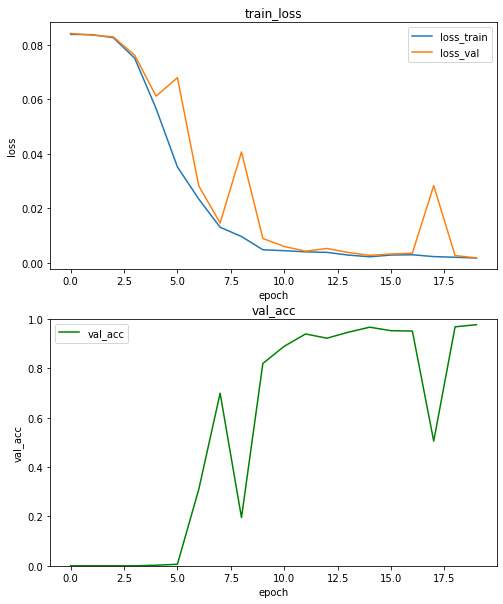

In [ ]:
# 浅层模型（5层）
plot_loss(train_loss[-20:],val_loss[-20:],val_acc[-20:])

In [ ]:
# 深层模型（10层）
plot_loss(train_loss,val_loss,val_acc)

### 离线模式（离线数据集）
这个模式分成两个阶段
*   数据采样（验证码生成）
*   模型训练

In [ ]:
# 生成数据
# 生成训练数据
captcha_gen(model_choose='test',num=1000)
#  captcha_gen(model_choose='train',num=80000)
#  captcha_gen(model_choose='val',num=1000)

saved 1 : xXo8_1589185840.png
saved 2 : HD5y_1589185840.png
saved 3 : DcyP_1589185840.png
saved 4 : Rw0U_1589185840.png
saved 5 : 8GjS_1589185840.png
saved 6 : 0WGj_1589185840.png
saved 7 : vgGa_1589185840.png
saved 8 : dkH0_1589185840.png
saved 9 : H713_1589185840.png
saved 10 : PrYN_1589185840.png
saved 11 : dgpi_1589185840.png
saved 12 : pAay_1589185840.png
saved 13 : s0lS_1589185840.png
saved 14 : fEan_1589185840.png
saved 15 : jyoE_1589185840.png
saved 16 : pakj_1589185840.png
saved 17 : XBAJ_1589185840.png
saved 18 : 8m9S_1589185840.png
saved 19 : HoUo_1589185840.png
saved 20 : qAuh_1589185840.png
saved 21 : 9J0X_1589185840.png
saved 22 : Elkv_1589185840.png
saved 23 : ZSBw_1589185840.png
saved 24 : UZXE_1589185840.png
saved 25 : bGZU_1589185840.png
saved 26 : fqKY_1589185840.png
saved 27 : 9f4f_1589185840.png
saved 28 : RgzP_1589185840.png
saved 29 : cQiu_1589185840.png
saved 30 : 9q2i_1589185840.png
saved 31 : FQJ2_1589185840.png
saved 32 : CxXL_1589185840.png
saved 33 : dav3_1

In [ ]:
# 首次训练（粗调）
train_loss,val_loss,val_acc = train(num_epochs=15,train_model='acc_model',batch_size_train=64,learning_rate=0.001)

In [ ]:
# 接着训练（精调）
train_loss,val_loss,val_acc = fine_train(add_epoch=2,train_model='acc_model',batch_size_train=64,train_loss_rcd=train_loss,val_loss_rcd=val_loss,val_acc=val_acc,learning_rate = 0.0003)

In [ ]:
# 可视化结果
# 8层 无dropout
plot_loss(train_loss,val_loss,val_acc)

In [ ]:
# cnn_light,128*1024
# 10层 无dropout
plot_loss(train_loss,val_loss,val_acc)

In [ ]:
# 用测试集来
captcha_gen(model_choose='test',num=3000)

saved 1 : NMy0_1589175472.png
saved 2 : iwQr_1589175472.png
saved 3 : 64Dv_1589175472.png
saved 4 : rFdY_1589175472.png
saved 5 : CIcM_1589175472.png
saved 6 : 1FhX_1589175472.png
saved 7 : q3uq_1589175472.png
saved 8 : Qhaw_1589175472.png
saved 9 : HwpQ_1589175472.png
saved 10 : PbIS_1589175472.png
saved 11 : L9R3_1589175472.png
saved 12 : MJBe_1589175472.png
saved 13 : 8t81_1589175472.png
saved 14 : M3Is_1589175472.png
saved 15 : Tida_1589175472.png
saved 16 : 6rSK_1589175472.png
saved 17 : TlDJ_1589175472.png
saved 18 : 7ueN_1589175472.png
saved 19 : 9xWu_1589175473.png
saved 20 : vTDH_1589175473.png
saved 21 : F3Jl_1589175473.png
saved 22 : v61A_1589175473.png
saved 23 : neh3_1589175473.png
saved 24 : 3m8q_1589175473.png
saved 25 : jGxB_1589175473.png
saved 26 : aIku_1589175473.png
saved 27 : UJst_1589175473.png
saved 28 : 1xyk_1589175473.png
saved 29 : kjZu_1589175473.png
saved 30 : aTU1_1589175473.png
saved 31 : S4wQ_1589175473.png
saved 32 : DSl0_1589175473.png
saved 33 : elyy_1

In [ ]:
# 检测分类错误的字符
find_error(model)

load cnn net.


[(('o', '0'), 7),
 (('u', 'w'), 2),
 (('l', '5'), 1),
 (('p', 'P'), 1),
 (('Y', 'X'), 1),
 (('l', 'L'), 1),
 (('k', 'K'), 1),
 (('t', 'P'), 1),
 (('i', 'W'), 1),
 (('r', 'n'), 1),
 (('r', 'F'), 1),
 (('P', 'n'), 1),
 (('V', 'G'), 1),
 (('n', '0'), 1),
 (('Y', '4'), 1),
 (('S', 's'), 1),
 (('l', 'J'), 1),
 (('H', 'B'), 1),
 (('Q', 'o'), 1),
 (('v', 'q'), 1),
 (('G', 'V'), 1),
 (('2', 'm'), 1),
 (('U', 'v'), 1),
 (('z', 'Z'), 1),
 (('j', 'e'), 1)]

## 具体实验过程

In [ ]:
# 生成训练数据
 captcha_gen(model_choose='train',num=30000)

In [ ]:
! /opt/bin/nvidia-smi

In [ ]:
train_loss,val_loss,val_acc = fine_train(add_epoch=5,train_model='acc_model',batch_size_train=64,train_loss_rcd=train_loss,val_loss_rcd=val_loss,val_acc=val_acc,learning_rate = 0.001)

In [ ]:
# 62字符 60x160
plot_loss(train_loss,val_loss,val_acc)

In [ ]:
# 62字符 60x160
plot_loss(train_loss,val_loss,val_acc)

In [ ]:
# 62字符 28x73
plot_loss(train_loss,val_loss,val_acc)

In [ ]:
plot_loss(train_loss,val_loss,val_acc)

In [ ]:
# 深层的模型
plot_loss(train_loss,val_loss,val_acc)

In [ ]:
find_error()

In [ ]:
captcha_gen(model_choose='test',num=3000)

In [ ]:
test()

In [ ]:
torch.cuda.is_available()

In [ ]:
!pwd

In [ ]:
os.listdir()

In [ ]:
!/opt/bin/nvidia-smi